# UT3 – Procesamiento de Datos Masivos y Gestión de la Información
## Actividad práctica: Mini-pipeline de Big Data con Kafka (RA3 – Sistemas de Big Data)
En este notebook vamos a construir un **mini-pipeline de datos** que combine:
1. Ingesta batch (CSV/JSON → DataFrame)
2. Ingesta en streaming usando Apache Kafka (productor + consumidor)
3. Limpieza y preprocesamiento
4. Modelado de datos (conceptual y lógico)
5. Evaluación de calidad e integridad
6. Consultas para extracción de valor
**Resultado de Aprendizaje trabajado (RA3 – SPS):**
> Gestiona y almacena datos facilitando la búsqueda de respuestas en grandes conjuntos de datos.
Autor/a: Grupo 6
Fecha: **(dd/mm/aaaa)**

In [1]:
# @title Carga de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import kagglehub
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
print("Librerías de análisis de datos cargadas correctamente.")

Librerías de análisis de datos cargadas correctamente.


c:\Users\Alumno\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from kafka import KafkaProducer, KafkaConsumer
import json
import time

# ==============================================
# CONFIGURACIÓN DEL CLUSTER KAFKA (REMOTO)
# ==============================================
# IMPORTANTE: Configura las credenciales de acceso al servidor remoto

# 1) Servidores bootstrap del cluster Kafka (remoto)
# Prueba primero con 9092, si no funciona prueba con 443
KAFKA_BOOTSTRAP_SERVERS = ["varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092"]
# Alternativa si 9092 no funciona:
# KAFKA_BOOTSTRAP_SERVERS = ["varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:443"]

# 2) Nombre del topic a utilizar para la práctica
KAFKA_TOPIC = "bigdata_ut3"  # o "ut3_g1", "ut3_g2", etc. según tu grupo

# 3) ¿El cluster usa seguridad SASL?
USE_SASL_SSL = False  # Sin autenticación, solo PLAINTEXT

# 4) Configuración de seguridad (sin autenticación para este servidor)
KAFKA_SECURITY_CONFIG = {
    "security_protocol": "PLAINTEXT",  # Sin SSL y sin autenticación SASL
    # Timeouts aumentados para conexiones remotas
    "request_timeout_ms": 60000,  # 60 segundos
    "metadata_max_age_ms": 300000,  # 5 minutos
}

print("✅ Cliente Kafka preparado para conexión REMOTA.")
print(f"Bootstrap Server: {KAFKA_BOOTSTRAP_SERVERS[0]}")
print(f"Topic: {KAFKA_TOPIC}")
print(f"Security Protocol: {KAFKA_SECURITY_CONFIG['security_protocol']} (sin SSL, sin autenticación)")
print(f"Autenticación SASL: {'Activada' if USE_SASL_SSL else 'Desactivada'}")
print("\n✅ Configuración lista. No se requieren credenciales.")

✅ Cliente Kafka preparado para conexión REMOTA.
Bootstrap Server: varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092
Topic: bigdata_ut3
Security Protocol: PLAINTEXT (sin SSL, sin autenticación)
Autenticación SASL: Desactivada

✅ Configuración lista. No se requieren credenciales.


## 1. Descripción del dataset y metadatos

**Origen del dataset**: Kaggle

**Tipo de dato**: Estructurado (datos organizados en filas y columnas con atributos definidos)

**Metadatos básicos**:
- **Nombre del dataset**: Boeing Supplier List
- **Origen / URL**: https://www.kaggle.com/datasets/donnetew/boeing-supplier-list
- **Número aproximado de registros**: Variable (depende del dataset)
- **Número de columnas**: Variable (depende del dataset)
- **Temática**: Lista de proveedores de Boeing con información sobre empresas suministradoras
- **Formato**: CSV

**Descripción adicional**: Este dataset contiene información estructurada sobre los proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios a Boeing. El dataset puede incluir información como nombres de empresas, ubicaciones, tipos de productos/servicios, y otros datos relevantes sobre la cadena de suministro.

In [3]:
# @title 🧾 Metadatos del dataset (rellenar)
metadatos = {
    "nombre_dataset": "Boeing Supplier List",
    "origen": "Kaggle",
    "url_fuente": "https://www.kaggle.com/datasets/donnetew/boeing-supplier-list",
    "tipo_dato": "estructurado",
    "formato": "CSV",
    "descripcion": "Dataset con información sobre proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios. El dataset contiene información sobre la cadena de suministro de Boeing, incluyendo nombres de empresas, ubicaciones, tipos de productos/servicios y otros datos relevantes."
}
metadatos

{'nombre_dataset': 'Boeing Supplier List',
 'origen': 'Kaggle',
 'url_fuente': 'https://www.kaggle.com/datasets/donnetew/boeing-supplier-list',
 'tipo_dato': 'estructurado',
 'formato': 'CSV',
 'descripcion': 'Dataset con información sobre proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios. El dataset contiene información sobre la cadena de suministro de Boeing, incluyendo nombres de empresas, ubicaciones, tipos de productos/servicios y otros datos relevantes.'}

In [4]:
# @title Carga de datos (ingesta batch)
# Descargar el dataset - kagglehub devuelve la ruta donde se descargó
path = kagglehub.dataset_download("donnetew/boeing-supplier-list")

# Listar archivos en el directorio para ver qué archivo CSV contiene
import os
archivos = os.listdir(path)
print(f"Archivos en el directorio: {archivos}")

# Buscar el archivo CSV (puede tener diferentes nombres)
csv_files = [f for f in archivos if f.endswith('.csv')]
if csv_files:
    nombre_archivo = csv_files[0]  # Tomar el primer CSV encontrado
    print(f"\n📄 Cargando archivo: {nombre_archivo}")
    df = pd.read_csv(f"{path}/{nombre_archivo}")
else:
    # Si no se encuentra CSV, intentar con nombre común
    print("\n⚠️ No se encontró CSV, intentando con nombre común...")
    try:
        df = pd.read_csv(f"{path}/boeing-supplier-list.csv")
    except:
        # Último intento con cualquier archivo en el directorio
        df = pd.read_csv(f"{path}/{archivos[0]}")

# Opción B: Cargar desde archivo subido a Colab (descomentar si se usa)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv("NOMBRE_ARCHIVO.csv") # TODO

print("\nDimensiones del dataset (filas, columnas):", df.shape)
print("\nPrimeras filas del dataset:")
df.head()

Archivos en el directorio: ['Boeing Supplier List.csv']

📄 Cargando archivo: Boeing Supplier List.csv

Dimensiones del dataset (filas, columnas): (396, 3)

Primeras filas del dataset:


,Supplier,Country,Category
0,3M,USA,Chemicals
1,"3V Fasteners Company, Inc.",USA,Fasteners
2,"A&B Aerospace, Inc.",USA,Components
3,"Aadox Manufacturing Co, Inc.",USA,Fasteners
4,Accurate Bushing Company,USA,Bearings


In [5]:
# @title 🔍 Exploración inicial del dataset
print("Información general del dataset:")
df.info()
print("\nDescripción estadística de variables numéricas:")
display(df.describe())
print("\nPrimeras filas:")
display(df.head())
print("\nNúmero de valores nulos por columna:")
display(df.isnull().sum())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Supplier  396 non-null    object
 1   Country   396 non-null    object
 2   Category  396 non-null    object
dtypes: object(3)
memory usage: 9.4+ KB

Descripción estadística de variables numéricas:


,Supplier,Country,Category
count,396,396,396
unique,392,16,72
top,"BP Lubricants USA, Inc.",USA,Components
freq,2,324,77



Primeras filas:


,Supplier,Country,Category
0,3M,USA,Chemicals
1,"3V Fasteners Company, Inc.",USA,Fasteners
2,"A&B Aerospace, Inc.",USA,Components
3,"Aadox Manufacturing Co, Inc.",USA,Fasteners
4,Accurate Bushing Company,USA,Bearings



Número de valores nulos por columna:


Supplier    0
Country     0
Category    0
dtype: int64

## 2. Objetivos de negocio y preguntas clave
Define **al menos 3 preguntas de negocio** que quieras responder con este dataset.
Ejemplos:
- ¿Qué factores influyen más en X?
- ¿Qué tipo de clientes generan más ingresos?
- ¿Qué días/horas se concentra más actividad?
> Escribe aquí tus preguntas:
1. ¿Qué países concentran la mayor cantidad de proveedores en la cadena de suministro de Boeing? (Análisis de distribución geográfica y concentración de riesgo)
2. ¿Cuáles son las categorías de productos/servicios más comunes y cómo se distribuyen geográficamente? (Análisis de diversificación por categoría y país)
3. ¿Existe una dependencia geográfica excesiva en alguna categoría específica de proveedores? (Evaluación de riesgo de concentración geográfica por tipo de componente)

In [6]:
# @title 🔍 Test de conexión a Kafka (opcional - ejecutar antes del productor)
# Esta celda verifica que la conexión a Kafka funciona correctamente

print("🔍 Probando conexión a Kafka...")
print(f"Servidor: {KAFKA_BOOTSTRAP_SERVERS[0]}")
print(f"Topic: {KAFKA_TOPIC}")
print(f"Security Protocol: {KAFKA_SECURITY_CONFIG.get('security_protocol', 'N/A')}")
print(f"Autenticación: {'SASL activada' if USE_SASL_SSL else 'Sin autenticación (PLAINTEXT)'}")

try:
    # Intentar crear un productor de prueba con timeouts aumentados
    test_producer_config = {
        "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
        "value_serializer": lambda v: json.dumps(v).encode("utf-8"),
        "api_version": (2, 0, 0),  # Versión mínima compatible (evita usar versión 0 antigua)
        "request_timeout_ms": 60000,       # 60 segundos (reducido para fallar más rápido)
        "metadata_max_age_ms": 300000,     # 5 minutos
        "max_block_ms": 60000,            # 60 segundos
        "delivery_timeout_ms": 120000,     # 2 minutos
        "linger_ms": 10,                   # 10ms
    }
    
    if USE_SASL_SSL:
        test_producer_config.update(KAFKA_SECURITY_CONFIG)
    
    print("\n🔄 Intentando conectar el productor...")
    test_producer = KafkaProducer(**test_producer_config)
    print("✅ Productor de prueba creado exitosamente")
    
    # Intentar crear un consumidor de prueba
    test_consumer_config = {
        "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
        "auto_offset_reset": "earliest",
        "consumer_timeout_ms": 10000,      # 10 segundos
        "group_id": "test_connection",
        "value_deserializer": lambda m: json.loads(m.decode("utf-8")),
        "api_version": (2, 0, 0),  # Versión mínima compatible (evita usar versión 0 antigua)
        "request_timeout_ms": 60000,
        "metadata_max_age_ms": 300000,
    }
    
    if USE_SASL_SSL:
        test_consumer_config.update(KAFKA_SECURITY_CONFIG)
    
    print("🔄 Intentando conectar el consumidor...")
    test_consumer = KafkaConsumer(KAFKA_TOPIC, **test_consumer_config)
    print("✅ Consumidor de prueba creado exitosamente")
    
    # Verificar que el topic existe
    print("🔄 Verificando topic...")
    partitions = test_consumer.partitions_for_topic(KAFKA_TOPIC)
    if partitions:
        print(f"✅ Topic '{KAFKA_TOPIC}' encontrado con {len(partitions)} partición(es): {partitions}")
    else:
        print(f"⚠️ Topic '{KAFKA_TOPIC}' no encontrado o vacío")
        print("   El topic puede no existir aún, pero la conexión funciona.")
    
    test_producer.close()
    test_consumer.close()
    print("\n✅ Conexión a Kafka verificada correctamente. Puedes proceder con el productor.")
    
except Exception as e:
    error_type = type(e).__name__
    print(f"\n❌ Error de conexión ({error_type}): {e}")
    print("\n🔧 Posibles soluciones:")
    print("  1. Verifica que el servidor esté accesible desde tu red")
    print("  2. Verifica que el puerto sea correcto (9092 para PLAINTEXT)")
    print("  3. Verifica que el topic exista en el servidor")
    print("  4. Comprueba que no haya firewall bloqueando la conexión")
    print("  5. Verifica que la URL del servidor sea correcta")
    print("\n💡 Verifica:")
    print("   - Que el puerto sea correcto (generalmente 9092 para PLAINTEXT)")
    print("   - Que el servidor esté en línea y accesible")
    print("   - Que la URL del servidor sea correcta")
    raise

🔍 Probando conexión a Kafka...
Servidor: varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092
Topic: bigdata_ut3
Security Protocol: PLAINTEXT
Autenticación: Sin autenticación (PLAINTEXT)

🔄 Intentando conectar el productor...
✅ Productor de prueba creado exitosamente
🔄 Intentando conectar el consumidor...
✅ Consumidor de prueba creado exitosamente
🔄 Verificando topic...
⚠️ Topic 'bigdata_ut3' no encontrado o vacío
   El topic puede no existir aún, pero la conexión funciona.

✅ Conexión a Kafka verificada correctamente. Puedes proceder con el productor.


In [7]:
# @title Productor Kafka: envío del dataset fila a fila

# Configuración del productor con timeouts aumentados
producer_config = {
    "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
    "value_serializer": lambda v: json.dumps(v).encode("utf-8"),
    # Versión de API: usar versión mínima compatible (2.0.0) para evitar errores de versión antigua
    "api_version": (2, 0, 0),  # Versión mínima compatible con servidores Kafka modernos
    # Configuración de timeouts aumentados
    "request_timeout_ms": 300000,      # 5 minutos para requests
    "metadata_max_age_ms": 300000,     # 5 minutos para refrescar metadatos
    "max_block_ms": 300000,            # 5 minutos máximo para bloquear
    "delivery_timeout_ms": 600000,     # 10 minutos (debe ser > linger_ms + request_timeout_ms)
    "retries": 5,                       # Número de reintentos
    "retry_backoff_ms": 1000,           # Esperar 1 segundo entre reintentos
    # Configuración de envío en lotes
    "batch_size": 16384,                # Tamaño del lote en bytes
    "linger_ms": 10,                   # Esperar 10ms antes de enviar el lote
    "buffer_memory": 33554432,          # 32MB de buffer en memoria
}

if USE_SASL_SSL:
    producer_config.update(KAFKA_SECURITY_CONFIG)

try:
    producer = KafkaProducer(**producer_config)
    print(f"✅ Productor conectado a Kafka")
    print(f"   Configuración: timeouts={producer_config['request_timeout_ms']/1000}s, retries={producer_config['retries']}")
except Exception as e:
    print(f"❌ Error al crear el productor: {e}")
    raise

# Convertir DataFrame a lista de diccionarios (cada fila = mensaje)
registros = df.to_dict(orient="records")
print(f"\n📤 Enviando {len(registros)} mensajes al topic '{KAFKA_TOPIC}'...")
print(f"   Esto puede tardar varios minutos...\n")

try:
    mensajes_enviados = 0
    mensajes_fallidos = 0
    
    # Enviar mensajes en lotes con flush periódico
    for i, fila in enumerate(registros):
        try:
            future = producer.send(KAFKA_TOPIC, value=fila)
            mensajes_enviados += 1
            
            # Mostrar progreso cada 500 mensajes
            if (i + 1) % 500 == 0:
                # Hacer flush cada 500 mensajes para asegurar el envío
                producer.flush(timeout=30)
                print(f"  ✅ Progreso: {i + 1}/{len(registros)} mensajes enviados...")
            
        except Exception as e:
            mensajes_fallidos += 1
            if mensajes_fallidos <= 5:  # Mostrar solo los primeros 5 errores
                print(f"  ⚠️ Error enviando mensaje {i+1}: {e}")
    
    # Flush final para asegurar que todos los mensajes se envíen
    print("\n🔄 Enviando mensajes pendientes...")
    producer.flush(timeout=60)
    
    print(f"\n✅ Envío completado:")
    print(f"   Mensajes enviados: {mensajes_enviados}/{len(registros)}")
    if mensajes_fallidos > 0:
        print(f"   Mensajes fallidos: {mensajes_fallidos}")
    
except Exception as e:
    print(f"\n❌ Error durante el envío: {e}")
    print(f"   Mensajes enviados antes del error: {mensajes_enviados}")
    raise
finally:
    producer.close()
    print("🔒 Productor cerrado")

✅ Productor conectado a Kafka
   Configuración: timeouts=300.0s, retries=5

📤 Enviando 396 mensajes al topic 'bigdata_ut3'...
   Esto puede tardar varios minutos...




🔄 Enviando mensajes pendientes...

✅ Envío completado:
   Mensajes enviados: 396/396
🔒 Productor cerrado


In [8]:
# @title Consumidor Kafka: lectura y reconstrucción del DataFrame

# Configuración básica del consumidor
consumer_config = {
    "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
    "auto_offset_reset": "earliest",  # empezamos desde el inicio del topic
    "enable_auto_commit": True,
    "group_id": "grupo_ut3",          # TODO: se puede personalizar por grupo
    "value_deserializer": lambda m: json.loads(m.decode("utf-8")),
    "consumer_timeout_ms": 300000,    # Timeout de 5 minutos para leer todos los mensajes
    # Versión de API: usar versión mínima compatible (2.0.0) para evitar errores de versión antigua
    "api_version": (2, 0, 0)  # Versión mínima compatible con servidores Kafka modernos
}

# Aplicar seguridad si está activada
if USE_SASL_SSL:
    consumer_config.update(KAFKA_SECURITY_CONFIG)

# Instancia del consumidor
try:
    consumer = KafkaConsumer(KAFKA_TOPIC, **consumer_config)
    print(f"✅ Consumidor conectado al topic '{KAFKA_TOPIC}'")
except Exception as e:
    print(f"❌ Error al crear el consumidor: {e}")
    raise

registros_consumidos = []

# IMPORTANTE: 'df' debe existir en memoria (de una celda anterior de carga de datos)
try:
    MAX_MENSAJES = df.shape[0]
    print(f"Objetivo: leer {MAX_MENSAJES} mensajes del topic...")
except NameError:
    print("⚠️ Advertencia: 'df' no está definido. Leyendo todos los mensajes disponibles...")
    MAX_MENSAJES = float('inf')  # Leer todos los mensajes disponibles

print("Leyendo mensajes del topic...")

# Bucle de consumo con manejo de timeout
try:
    mensajes_leidos = 0
    for msg in consumer:
        registros_consumidos.append(msg.value)
        mensajes_leidos += 1
        
        # Mostrar progreso cada 100 mensajes
        if mensajes_leidos % 100 == 0:
            print(f"  Progreso: {mensajes_leidos} mensajes leídos...")
        
        # Condición de parada
        if len(registros_consumidos) >= MAX_MENSAJES:
            print(f"✅ Se alcanzó el objetivo de {MAX_MENSAJES} mensajes")
            break
            
except StopIteration:
    # Esto ocurre cuando se agota el timeout
    print(f"⏱️ Timeout alcanzado. Mensajes leídos hasta ahora: {len(registros_consumidos)}")
except KeyboardInterrupt:
    print(f"\n⚠️ Interrupción manual. Mensajes leídos: {len(registros_consumidos)}")
except Exception as e:
    print(f"❌ Error durante la lectura: {e}")
finally:
    # Cerrar el consumidor explícitamente
    consumer.close()
    print("🔒 Consumidor cerrado")

print(f"\n📊 Total de mensajes leídos desde Kafka: {len(registros_consumidos)}")

# Crear DataFrame y mostrar resultados
if len(registros_consumidos) > 0:
    df_stream = pd.DataFrame(registros_consumidos)
    print(f"\n✅ DataFrame reconstruido exitosamente")
    display(df_stream.head())
    print(f"\nDimensiones de df_stream: {df_stream.shape}")
    print(f"Columnas: {list(df_stream.columns)}")
    
    # Comparar con el DataFrame original si existe
    try:
        if len(registros_consumidos) == df.shape[0]:
            print(f"\n✅ Coincide con el DataFrame original ({df.shape[0]} filas)")
        else:
            print(f"\n⚠️ Diferencia: Original tenía {df.shape[0]} filas, stream tiene {len(registros_consumidos)}")
    except NameError:
        pass
else:
    print("⚠️ No se leyeron mensajes. Verifica:")
    print("  1. Que el productor haya enviado mensajes")
    print("  2. Que el topic sea correcto")
    print("  3. Que las credenciales sean válidas")
    df_stream = pd.DataFrame()  # DataFrame vacío para evitar errores posteriores

✅ Consumidor conectado al topic 'bigdata_ut3'
Objetivo: leer 396 mensajes del topic...
Leyendo mensajes del topic...
  Progreso: 100 mensajes leídos...
  Progreso: 200 mensajes leídos...
  Progreso: 300 mensajes leídos...
✅ Se alcanzó el objetivo de 396 mensajes
🔒 Consumidor cerrado

📊 Total de mensajes leídos desde Kafka: 396

✅ DataFrame reconstruido exitosamente


,Supplier,Country,Category
0,Acument Global Technologies,USA,Fasteners
1,Advanced Micro Lites,USA,Lighting
2,Aerospace Products Company,USA,Components
3,Air Industries Corporation,USA,Components
4,Airdrome Precision Components,USA,Components



Dimensiones de df_stream: (396, 3)
Columnas: ['Supplier', 'Country', 'Category']

✅ Coincide con el DataFrame original (396 filas)


In [9]:
# @title Limpieza básica sobre df_stream
df_clean = df_stream.copy()
print("Registros duplicados antes de limpiar:", df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()
print("Registros duplicados después de limpiar:", df_clean.duplicated().sum())
print("\nValores nulos por columna (antes de imputar):")
display(df_clean.isnull().sum())
# TODO: definir estrategia de imputación según el dataset
# Ejemplo para columnas numéricas: imputar con la mediana
numeric_cols_tmp = df_clean.select_dtypes(include=["int64", "float64"]).columns
df_clean[numeric_cols_tmp] = df_clean[numeric_cols_tmp].fillna(df_clean[numeric_cols_tmp].median())
print("\nValores nulos por columna (después de imputar numéricas):")
display(df_clean.isnull().sum())
df_clean.head()

Registros duplicados antes de limpiar: 94
Registros duplicados después de limpiar: 0

Valores nulos por columna (antes de imputar):


Supplier    0
Country     0
Category    0
dtype: int64


Valores nulos por columna (después de imputar numéricas):


Supplier    0
Country     0
Category    0
dtype: int64

,Supplier,Country,Category
0,Acument Global Technologies,USA,Fasteners
1,Advanced Micro Lites,USA,Lighting
2,Aerospace Products Company,USA,Components
3,Air Industries Corporation,USA,Components
4,Airdrome Precision Components,USA,Components


In [10]:
# @title Boxplots para detección de outliers (opcional)
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
print("Columnas numéricas:", list(numeric_cols))

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

# TODO: decidir si se filtran o transforman outliers en alguna columna

Columnas numéricas: []


## 3. Modelado de datos (conceptual y lógico)
En esta sección diseña:
1. **Modelo conceptual**
- Entidades principales (ej.: Cliente, Pedido, Producto, etc.)
- Relaciones entre entidades (ej.: Cliente — realiza — Pedido)
2. **Modelo lógico**
- Elige el tipo de modelo de almacenamiento:
- Relacional (tablas SQL)
- NoSQL documental (MongoDB)
- Columnar (Cassandra)
- Clave-valor (Redis)
- Grafos (Neo4j)
- Justifica la elección:
- Tipo de consultas
- Volumen y variedad de los datos
- Necesidades de escalabilidad / rendimiento
> Adjunta o describe aquí tu modelo (texto, tabla resumen o enlace a un diagrama).

In [11]:
# @title Selección de variables y pipeline de preprocesamiento
df_model = df_clean.copy()

# TODO: definir variable objetivo (si procede). Si no hay objetivo, dejar a None.
target = None # p.ej.: "tip" en el dataset 'tips'

if target is not None and target in df_model.columns:
    features = [col for col in df_model.columns if col != target]
    X = df_model[features].copy()
    y = df_model[target].copy()
else:
    features = list(df_model.columns)
    X = df_model.copy()
    y = None

print("Features:", features)
print("Target:", target if target is not None and target in df_model.columns else "No se ha definido variable objetivo")

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

print("\nColumnas numéricas:", list(numeric_features))
print("Columnas categóricas:", list(categorical_features))

# Transformador numérico: escalado MinMax
numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

# Transformador categórico: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.copy()
    X_test = X.copy()

preprocessor.fit(X_train)
print("\n✅ Preprocesador ajustado correctamente.")

Features: ['Supplier', 'Country', 'Category']
Target: No se ha definido variable objetivo

Columnas numéricas: []
Columnas categóricas: ['Supplier', 'Country', 'Category']

✅ Preprocesador ajustado correctamente.


In [12]:
# @title Transformación y guardado de datos procesados
X_train_transformed = preprocessor.transform(X_train)
print("Shape de X_train transformado:", X_train_transformed.shape)

# Intento convertir a DataFrame (puede ser grande)
try:
    X_train_dense = pd.DataFrame(
        X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
    )
    display(X_train_dense.head())
except Exception as e:
    print("No se ha podido convertir a DataFrame por tamaño/formato:", e)

# Guardar conjunto limpio (sin codificación) como ejemplo
df_clean.to_csv("datos_procesados.csv", index=False)
df_clean.to_parquet("datos_procesados.parquet", index=False)
print("Archivos 'datos_procesados.csv' y 'datos_procesados.parquet' guardados.")

Shape de X_train transformado: (302, 376)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Archivos 'datos_procesados.csv' y 'datos_procesados.parquet' guardados.


## 4. Calidad del dato e integridad
Evalúa la calidad de tu dataset **después del preprocesamiento**:
- **Exactitud**: ¿Los datos parecen razonables / realistas?
- **Completitud**: ¿Qué porcentaje de nulos queda? ¿En qué columnas?
- **Consistencia**: ¿Hay valores contradictorios o incoherentes?
- **Unicidad**: ¿Persisten duplicados?
- **Oportunidad**: ¿Los datos siguen siendo válidos / actuales para el problema?
> Escribe aquí un breve análisis de calidad del dato y las decisiones tomadas en tu pipeline.

In [13]:
# @title Métricas simples de calidad del dato
n_filas, n_cols = df_clean.shape
porcentaje_nulos = (df_clean.isnull().sum() / n_filas) * 100
duplicados = df_clean.duplicated().sum()
print("Número de filas:", n_filas)
print("Número de columnas:", n_cols)
print("\nPorcentaje de nulos por columna:")
display(porcentaje_nulos)
print("\nNúmero de registros duplicados:", duplicados)

Número de filas: 302
Número de columnas: 3

Porcentaje de nulos por columna:


Supplier    0.0
Country     0.0
Category    0.0
dtype: float64


Número de registros duplicados: 0


CONSULTAS DE NEGOCIO - PROVEEDORES DE BOEING

📊 PREGUNTA 1: Distribución geográfica de proveedores
--------------------------------------------------------------------------------

Top 10 países con más proveedores:


,Num_Proveedores,Porcentaje,Porcentaje_Acumulado
Country,,,
USA,245,81.13,81.13
UK,13,4.30,85.43
France,13,4.30,89.73
Germany,9,2.98,92.71
Japan,3,0.99,93.70
Netherlands,3,0.99,94.69
Italy,3,0.99,95.68
Switzerland,3,0.99,96.67
India,2,0.66,97.33



📈 Total de países únicos: 15
📈 País con más proveedores: USA (245.0 proveedores, 81.13%)


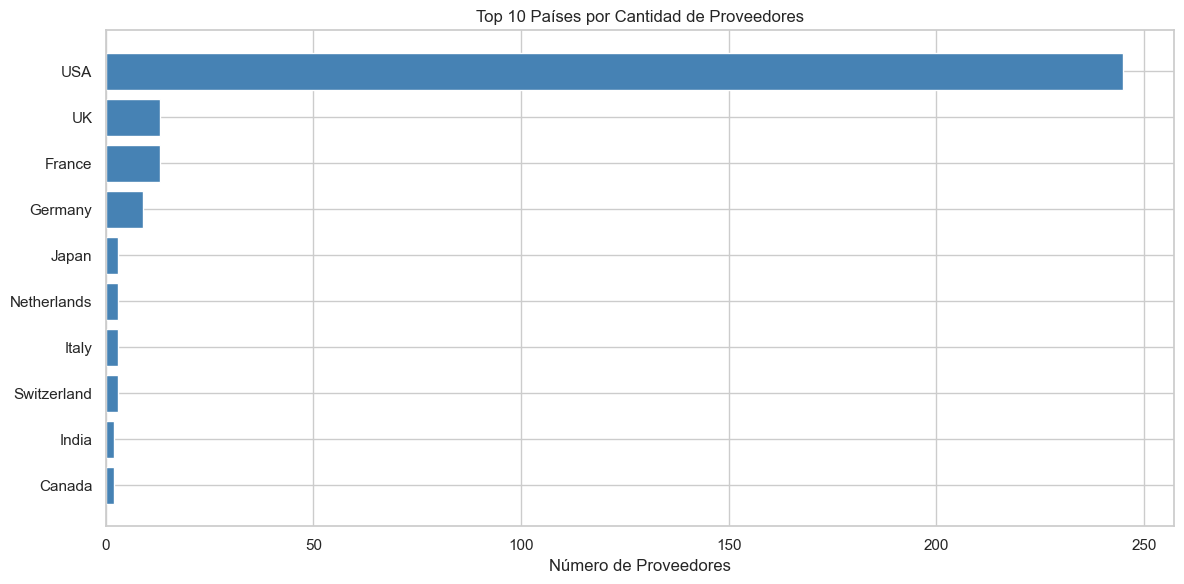



📊 PREGUNTA 2: Categorías más comunes y distribución geográfica
--------------------------------------------------------------------------------

Categorías ordenadas por frecuencia:


,Num_Proveedores,Porcentaje
Category,,
Components,59,19.54
Fasteners,48,15.89
Seals,23,7.62
Bearings,14,4.64
Hardware,13,4.30
...,...,...
Rings,1,0.33
Relays,1,0.33
Structures/Systems,1,0.33




Distribución geográfica por categoría (Top 5 categorías):

📍 Components:


,Proveedores,Porcentaje
Country,,
USA,50,84.75
France,3,5.08
UK,2,3.39
Germany,1,1.69
Canada,1,1.69



📍 Fasteners:


,Proveedores,Porcentaje
Country,,
USA,42,87.50
France,2,4.17
Germany,1,2.08
India,1,2.08
Italy,1,2.08



📍 Seals:


,Proveedores,Porcentaje
Country,,
USA,18,78.26
France,2,8.70
Germany,1,4.35
Sweden,1,4.35
UK,1,4.35



📍 Bearings:


,Proveedores,Porcentaje
Country,,
USA,9,64.29
Germany,2,14.29
Canada,1,7.14
Japan,1,7.14
UK,1,7.14



📍 Hardware:


,Proveedores,Porcentaje
Country,,
USA,10,76.92
Italy,1,7.69
Taiwan,1,7.69
UK,1,7.69




Tabla cruzada: Top 5 Países x Top 5 Categorías


Category,Bearings,Components,Fasteners,Hardware,Seals
Country,,,,,
France,0,3,2,0,2
Germany,2,1,1,0,1
Japan,1,0,0,0,0
UK,1,2,0,1,1
USA,9,50,42,10,18


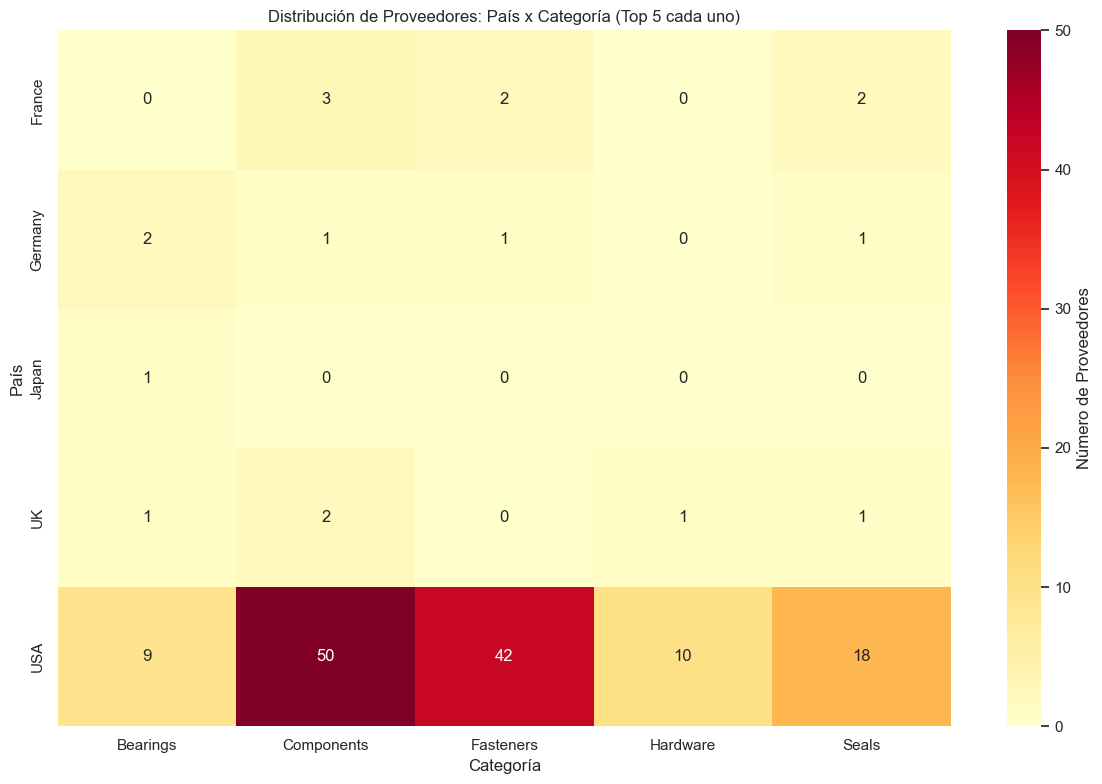



📊 PREGUNTA 3: Análisis de riesgo de concentración geográfica por categoría
--------------------------------------------------------------------------------

Análisis de concentración geográfica por categoría:
(HHI cercano a 1 = alta concentración, cercano a 0 = alta diversificación)


,Category,Total_Proveedores,Paises_Unicos,Pais_Dominante,Porcentaje_Pais_Dominante,Indice_Concentracion_HHI
4,Lubrication,1,1,USA,100.00,1.000
5,Seals/Tools,1,1,USA,100.00,1.000
10,Protective,2,1,USA,100.00,1.000
11,Antennas,1,1,UK,100.00,1.000
12,Tools,3,1,USA,100.00,1.000
...,...,...,...,...,...,...
28,Coatings,6,3,USA,66.67,0.500
50,Landing Gear,2,2,France,50.00,0.500
40,Switches,2,2,France,50.00,0.500
49,Composites,2,2,UK,50.00,0.500



⚠️ CATEGORÍAS CON ALTO RIESGO DE CONCENTRACIÓN GEOGRÁFICA:
--------------------------------------------------------------------------------

🔴 Lubrication:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Seals/Tools:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Protective:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Antennas:
   - 100.0% de proveedores están en UK
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Tools:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Distribution:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Batteries:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - So

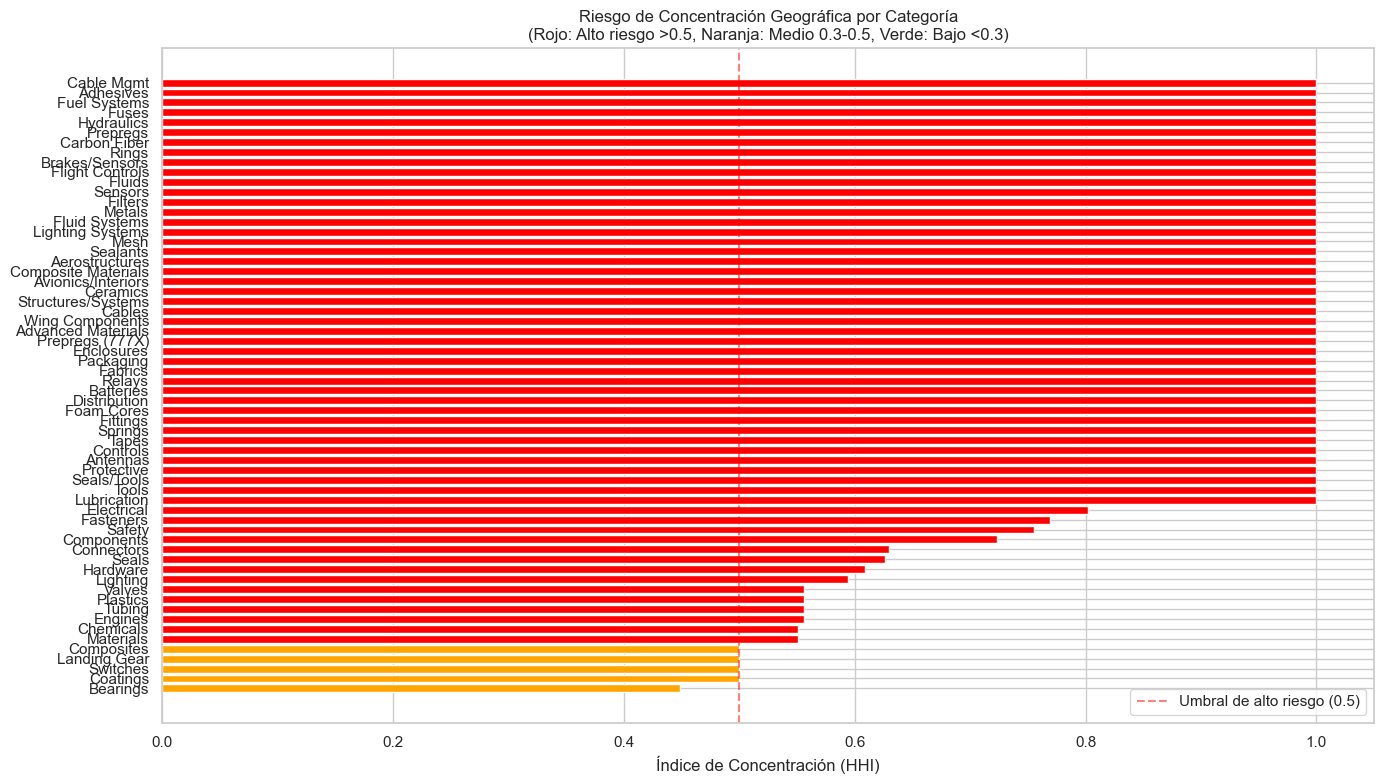


✅ Análisis completado


In [14]:
# @title Consultas de negocio y agregaciones

print("=" * 80)
print("CONSULTAS DE NEGOCIO - PROVEEDORES DE BOEING")
print("=" * 80)

# ============================================================================
# PREGUNTA 1: ¿Qué países concentran la mayor cantidad de proveedores?
# ============================================================================
print("\n📊 PREGUNTA 1: Distribución geográfica de proveedores")
print("-" * 80)

proveedores_por_pais = df_clean.groupby("Country").agg({
    "Supplier": "count"
}).rename(columns={"Supplier": "Num_Proveedores"}).sort_values("Num_Proveedores", ascending=False)

proveedores_por_pais["Porcentaje"] = (proveedores_por_pais["Num_Proveedores"] / len(df_clean) * 100).round(2)
proveedores_por_pais["Porcentaje_Acumulado"] = proveedores_por_pais["Porcentaje"].cumsum()

print("\nTop 10 países con más proveedores:")
display(proveedores_por_pais.head(10))

print(f"\n📈 Total de países únicos: {df_clean['Country'].nunique()}")
print(f"📈 País con más proveedores: {proveedores_por_pais.index[0]} ({proveedores_por_pais.iloc[0]['Num_Proveedores']} proveedores, {proveedores_por_pais.iloc[0]['Porcentaje']}%)")

# Visualización
plt.figure(figsize=(12, 6))
top_10_paises = proveedores_por_pais.head(10)
plt.barh(range(len(top_10_paises)), top_10_paises["Num_Proveedores"], color='steelblue')
plt.yticks(range(len(top_10_paises)), top_10_paises.index)
plt.xlabel("Número de Proveedores")
plt.title("Top 10 Países por Cantidad de Proveedores")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# PREGUNTA 2: ¿Cuáles son las categorías más comunes y su distribución geográfica?
# ============================================================================
print("\n\n📊 PREGUNTA 2: Categorías más comunes y distribución geográfica")
print("-" * 80)

# Análisis de categorías
categorias_por_frecuencia = df_clean.groupby("Category").agg({
    "Supplier": "count"
}).rename(columns={"Supplier": "Num_Proveedores"}).sort_values("Num_Proveedores", ascending=False)

categorias_por_frecuencia["Porcentaje"] = (categorias_por_frecuencia["Num_Proveedores"] / len(df_clean) * 100).round(2)

print("\nCategorías ordenadas por frecuencia:")
display(categorias_por_frecuencia)

# Distribución geográfica por categoría
print("\n\nDistribución geográfica por categoría (Top 5 categorías):")
top_5_categorias = categorias_por_frecuencia.head(5).index

for categoria in top_5_categorias:
    print(f"\n📍 {categoria}:")
    distribucion = df_clean[df_clean["Category"] == categoria].groupby("Country").size().sort_values(ascending=False)
    distribucion_pct = (distribucion / distribucion.sum() * 100).round(2)
    resultado = pd.DataFrame({
        "Proveedores": distribucion,
        "Porcentaje": distribucion_pct
    }).head(5)
    display(resultado)

# Tabla cruzada: País x Categoría (solo top países y categorías)
print("\n\nTabla cruzada: Top 5 Países x Top 5 Categorías")
tabla_cruzada = pd.crosstab(
    df_clean[df_clean["Country"].isin(proveedores_por_pais.head(5).index)]["Country"],
    df_clean[df_clean["Category"].isin(top_5_categorias)]["Category"]
)
display(tabla_cruzada)

# Visualización: Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tabla_cruzada, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Número de Proveedores'})
plt.title("Distribución de Proveedores: País x Categoría (Top 5 cada uno)")
plt.xlabel("Categoría")
plt.ylabel("País")
plt.tight_layout()
plt.show()

# ============================================================================
# PREGUNTA 3: ¿Existe dependencia geográfica excesiva en alguna categoría?
# ============================================================================
print("\n\n📊 PREGUNTA 3: Análisis de riesgo de concentración geográfica por categoría")
print("-" * 80)

# Calcular índice de concentración (HHI - Herfindahl-Hirschman Index) por categoría
# HHI = suma de (porcentaje de cada país)^2
# Valores cercanos a 1 indican alta concentración, valores cercanos a 0 indican diversificación

concentracion_por_categoria = []

for categoria in df_clean["Category"].unique():
    datos_categoria = df_clean[df_clean["Category"] == categoria]
    distribucion_pais = datos_categoria["Country"].value_counts(normalize=True)
    hhi = (distribucion_pais ** 2).sum()  # Índice de concentración
    pais_dominante = distribucion_pais.index[0]
    porcentaje_dominante = distribucion_pais.iloc[0] * 100
    
    concentracion_por_categoria.append({
        "Category": categoria,
        "Total_Proveedores": len(datos_categoria),
        "Paises_Unicos": datos_categoria["Country"].nunique(),
        "Pais_Dominante": pais_dominante,
        "Porcentaje_Pais_Dominante": round(porcentaje_dominante, 2),
        "Indice_Concentracion_HHI": round(hhi, 3)
    })

df_concentracion = pd.DataFrame(concentracion_por_categoria).sort_values("Indice_Concentracion_HHI", ascending=False)

print("\nAnálisis de concentración geográfica por categoría:")
print("(HHI cercano a 1 = alta concentración, cercano a 0 = alta diversificación)")
display(df_concentracion)

# Identificar categorías con alto riesgo (HHI > 0.5 o país dominante > 70%)
categorias_riesgo = df_concentracion[
    (df_concentracion["Indice_Concentracion_HHI"] > 0.5) | 
    (df_concentracion["Porcentaje_Pais_Dominante"] > 70)
]

if len(categorias_riesgo) > 0:
    print("\n⚠️ CATEGORÍAS CON ALTO RIESGO DE CONCENTRACIÓN GEOGRÁFICA:")
    print("-" * 80)
    for _, row in categorias_riesgo.iterrows():
        print(f"\n🔴 {row['Category']}:")
        print(f"   - {row['Porcentaje_Pais_Dominante']}% de proveedores están en {row['Pais_Dominante']}")
        print(f"   - Índice de concentración (HHI): {row['Indice_Concentracion_HHI']}")
        print(f"   - Solo {row['Paises_Unicos']} país(es) diferentes")
else:
    print("\n✅ No se detectaron categorías con concentración geográfica excesiva.")

# Visualización: Concentración por categoría
plt.figure(figsize=(14, 8))
categorias_ordenadas = df_concentracion.sort_values("Indice_Concentracion_HHI", ascending=True)["Category"]
hhi_values = df_concentracion.sort_values("Indice_Concentracion_HHI", ascending=True)["Indice_Concentracion_HHI"]

plt.barh(range(len(categorias_ordenadas)), hhi_values, color=['red' if h > 0.5 else 'orange' if h > 0.3 else 'green' for h in hhi_values])
plt.yticks(range(len(categorias_ordenadas)), categorias_ordenadas)
plt.xlabel("Índice de Concentración (HHI)")
plt.title("Riesgo de Concentración Geográfica por Categoría\n(Rojo: Alto riesgo >0.5, Naranja: Medio 0.3-0.5, Verde: Bajo <0.3)")
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Umbral de alto riesgo (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ Análisis completado")
print("=" * 80)

## 5. Conclusiones del mini-pipeline
1. **Resumen del proceso**
- Describe brevemente las etapas: ingesta batch, envío a Kafka, consumo desde Kafka,
limpieza, modelado, calidad del dato y consultas.
2. **Respuestas a las preguntas de negocio**
- ¿Qué has podido responder?
- ¿Qué patrones o insights relevantes has obtenido?
3. **Limitaciones y mejoras**
- ¿Qué harías mejor si tuvieras más tiempo o más herramientas (Spark, MongoDB, etc.)?
- ¿Qué otras fuentes de datos podrían enriquecer el análisis?
4. **Relación con el RA3 de Sistemas de Big Data**
- Explica en 4–5 líneas cómo este mini-pipeline te ha permitido:
- gestionar datos,
- almacenarlos de forma apropiada,
- y facilitar la búsqueda de respuestas en grandes conjuntos de datos.